In [21]:
import pandas as pd;
import os;
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_files_in_directory(path: str):
    """
    Returns a list of files in a directory.
    """
    return os.listdir(path)

def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

def convert_date_column_to_datetime(df: pd.DataFrame):
    """
    Converts the date column to datetime format.
    """
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.reset_index(drop=True) 
    return df

def visualize_line_plot(df: pd.DataFrame, labels: list[str], title: str, ax: plt.Axes):
    """
    Visualizes a line plot.
    """
    for label in labels:
        df.plot(x="Date", y=label, ax=ax, label=label)

    ax.set_title(title)
    ax.legend()

def visualize_area_of_volume(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes a histogram of the volume.
    """
    df.plot(x="Date", y="Volume", ax=ax, kind="area", color="green")
    ax.set_title("Volume")

def calculate_returns(df: pd.DataFrame):
    """
    Calculates the returns.
    """
    df["Returns"] = df["Adj Close"].pct_change()
    return df

def visualize_returns(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the returns.
    """
    df.plot(x="Date", y="Returns", ax=ax, linestyle=':', marker='o')
    ax.set_title("Returns")

def visualize_returns_displacement_plot(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the returns displacement plot.
    """
    sns.histplot(df["Returns"], ax=ax, kde=True)
    ax.set_title("Displacement of Returns")

def calculate_volatility(df: pd.DataFrame):
    """
    Calculates the volatility.
    """
    df["Volatility"] = df["Returns"].rolling(window=21).std() * np.sqrt(252)
    return df

def visualize_volatility(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the volatility.
    """
    df.plot(x="Date", y="Volatility", ax=ax)
    ax.set_title("Volatility")


def visualize_data(df: pd.DataFrame, labels: list[str], title: str):
    """
    Visualizes the data.
    """
    fig, plots = plt.subplots(4, 2, figsize=(48, 24), squeeze=False)
    fig.suptitle("Stock price over time, " + title, fontsize=16)

    df = calculate_returns(df)
    df = calculate_volatility(df)

    visualize_line_plot(df, labels, title, plots[0, 0])
    visualize_correlation(df, plots[1, 0])
    visualize_area_of_volume(df, plots[0, 1])
    visualize_returns(df, plots[1, 1])
    visualize_returns_displacement_plot(df, plots[2, 0])
    visualize_volatility(df, plots[2, 1])
    visualize_anomalies_in_stock(df, plots[3, 0])


    plt.show()

def visualize_correlation(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the correlation between columns.
    """

    df1 = df.iloc[:, 1:]
    correlations = df1.corr(method="spearman")
    sns.heatmap(correlations, cmap="Greens" , annot=True, ax=ax)
    ax.set_title("Correlation between columns")

def visualize_correlation_between_different_stock(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the correlation between different stocks.
    """
    correlations = df.corr(method="spearman")
    sns.heatmap(correlations, cmap="Greens" , annot=True, ax=ax)
    ax.set_title("Correlation between different stocks")

def visualize_correlation_between_different_stock_returns(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the correlation between different stocks' returns.
    """
    df_returns = df.pct_change()
    correlations = df_returns.corr(method="spearman")
    sns.heatmap(correlations, cmap="Greens" , annot=True, ax=ax)
    ax.set_title("Correlation between different stocks returns")

def calculate_average_volatility(df: pd.DataFrame):
    """
    Calculates the average volatility.
    """
    return df["Volatility"].mean()

def visualize_volatility_bar_chart(volatilities: dict, ax: plt.Axes):
    """
    Visualizes the volatility in a bar chart.
    """
    names = list(volatilities.keys())
    values = list(volatilities.values())

    colors = sns.color_palette("coolwarm", len(names))
    
    ax.bar(names, values, color=colors)
    ax.set_title("Average Volatility")
    ax.set_xlabel("Stock")
    ax.set_ylabel("Volatility")

def find_anomalies_in_stock(df: pd.DataFrame):
    """
    Finds anomalies in the stock.
    """
    mean = df["Returns"].mean()
    std = df["Returns"].std()

    z_scores = (df["Returns"] - mean) / std

    return df[(np.abs(z_scores) > 2.5)]

def visualize_anomalies_in_stock(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the anomalies in the stock.
    """
    anomalies = find_anomalies_in_stock(df)
    ax.plot(df["Date"], df["Adj Close"], label="Stock")
    ax.set_xticks(np.arange(0, len(df["Date"]), step=len(df["Date"]) / 8))
    ax.scatter(anomalies["Date"], anomalies["Adj Close"], color="red", label="Anomalies")
    ax.set_title("Anomalies in stock")
    ax.legend()

def visualize_overlap_of_anomalies(dfs: list[pd.DataFrame], files: list[str], ax: plt.Axes):
    """
    Visualizes the overlap of anomalies.
    """
    for i in range(len(dfs)):
        anomalies = find_anomalies_in_stock(dfs[i])
        ax.scatter(x = anomalies["Date"], y = anomalies["Returns"], label=files[i])
        
    ax.legend(files)
    ax.set_title("Overlap of anomalies")

def visualize_top_5_months_with_highest_overlapping_anomalies(dfs: list[pd.DataFrame], files: list[str], ax: plt.Axes):
    """
    Visualizes the top 5 months with the highest overlapping anomalies.
    """
    anomalies = {}
    for i in range(len(dfs)):
        anomalies[files[i]] = find_anomalies_in_stock(dfs[i])

    combined_anomalies = pd.concat(anomalies.values())
    combined_anomalies["Month"] = combined_anomalies["Date"].dt.to_period('M')
    top_5_months = combined_anomalies["Month"].value_counts().nlargest(5)
    colors = sns.color_palette("viridis", len(top_5_months))
    top_5_months.plot(kind="bar", ax=ax, color=colors, rot=45)
    ax.set_title("Top 5 months with highest overlapping anomalies")

    

def visualize_data_of_stocks_combined(dfs: list[pd.DataFrame], files: list[str]): 
    fig, plots = plt.subplots(3, 2, figsize=(32, 16), squeeze=False)
    fig.suptitle("Relationships between stocks", fontsize=16)

    combined_df_for_price_correlation = pd.DataFrame()
    combined_df_for_returns_correlation = pd.DataFrame()
    volatilities = {}
    for i in range(len(dfs)):
        calculate_returns(dfs[i])
        calculate_volatility(dfs[i])
        combined_df_for_price_correlation[files[i]] = dfs[i]["Adj Close"]
        combined_df_for_returns_correlation[files[i]] = dfs[i]["Returns"]
        volatilities[files[i]] = calculate_average_volatility(dfs[i])

    visualize_correlation_between_different_stock(combined_df_for_price_correlation, plots[0, 0])
    visualize_correlation_between_different_stock_returns(combined_df_for_returns_correlation, plots[0, 1])
    visualize_volatility_bar_chart(volatilities, plots[1, 0])
    visualize_overlap_of_anomalies(dfs, files, plots[1, 1])
    visualize_top_5_months_with_highest_overlapping_anomalies(dfs, files, plots[2, 1])

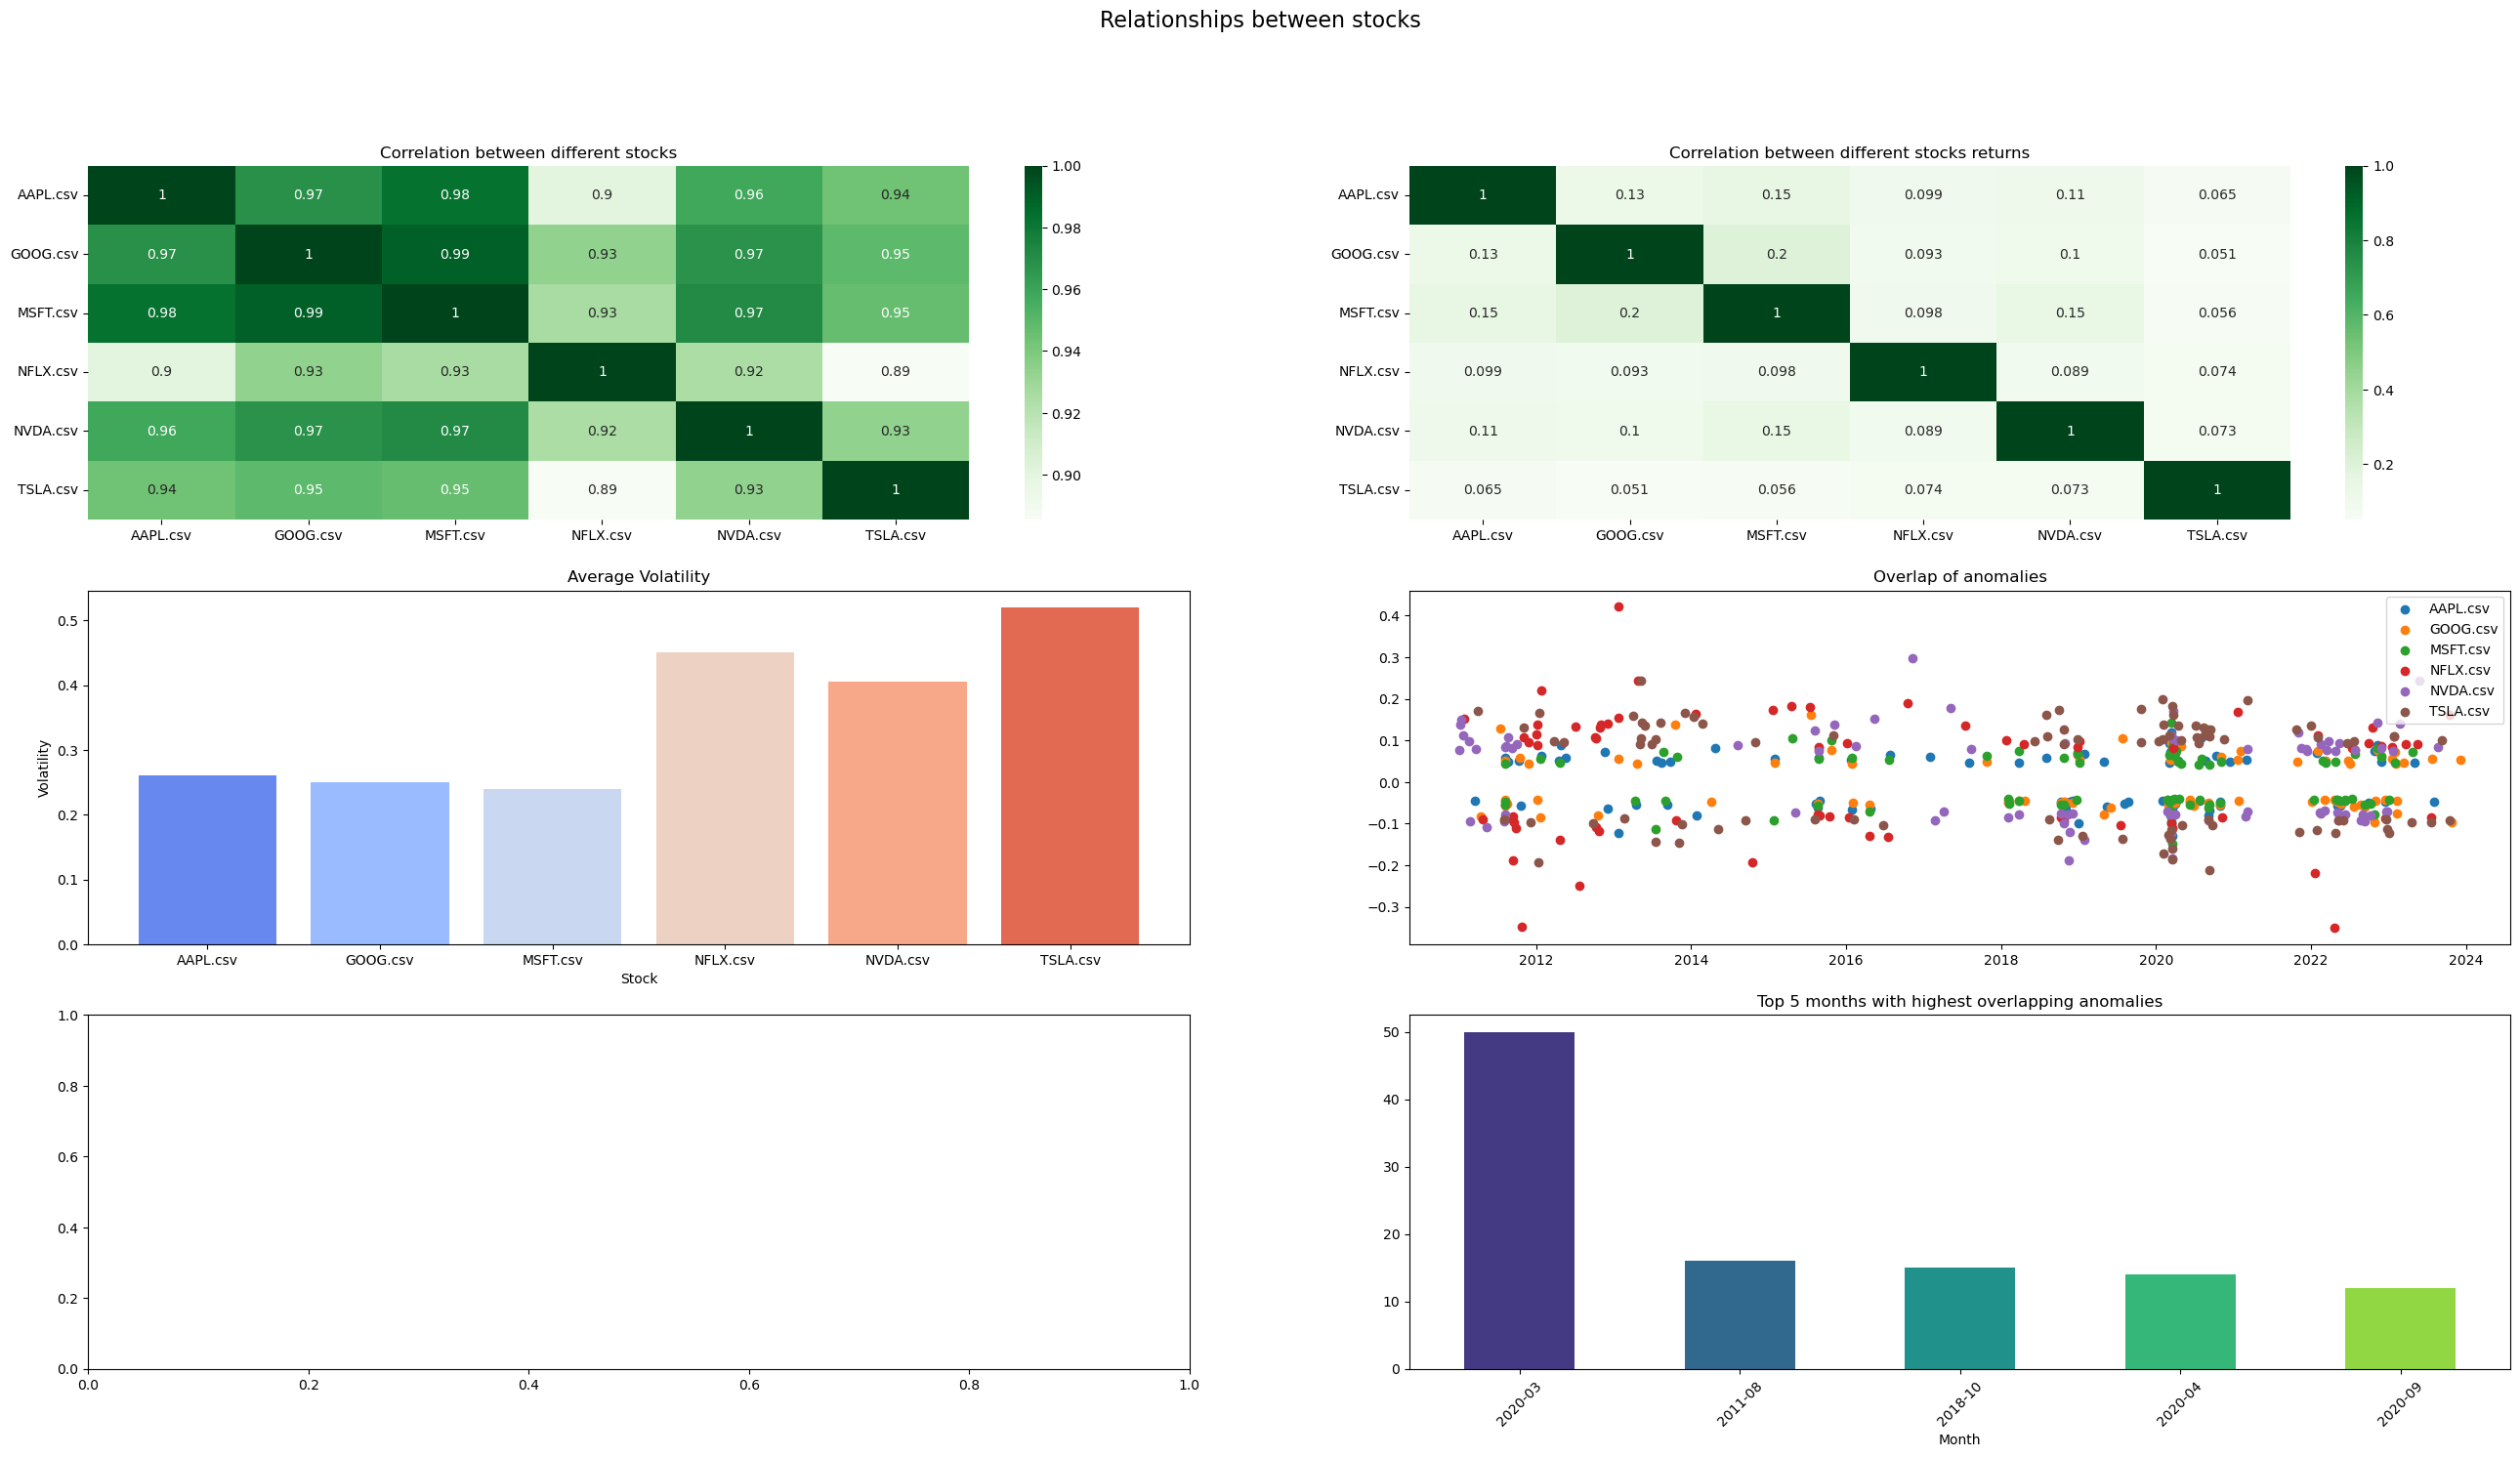

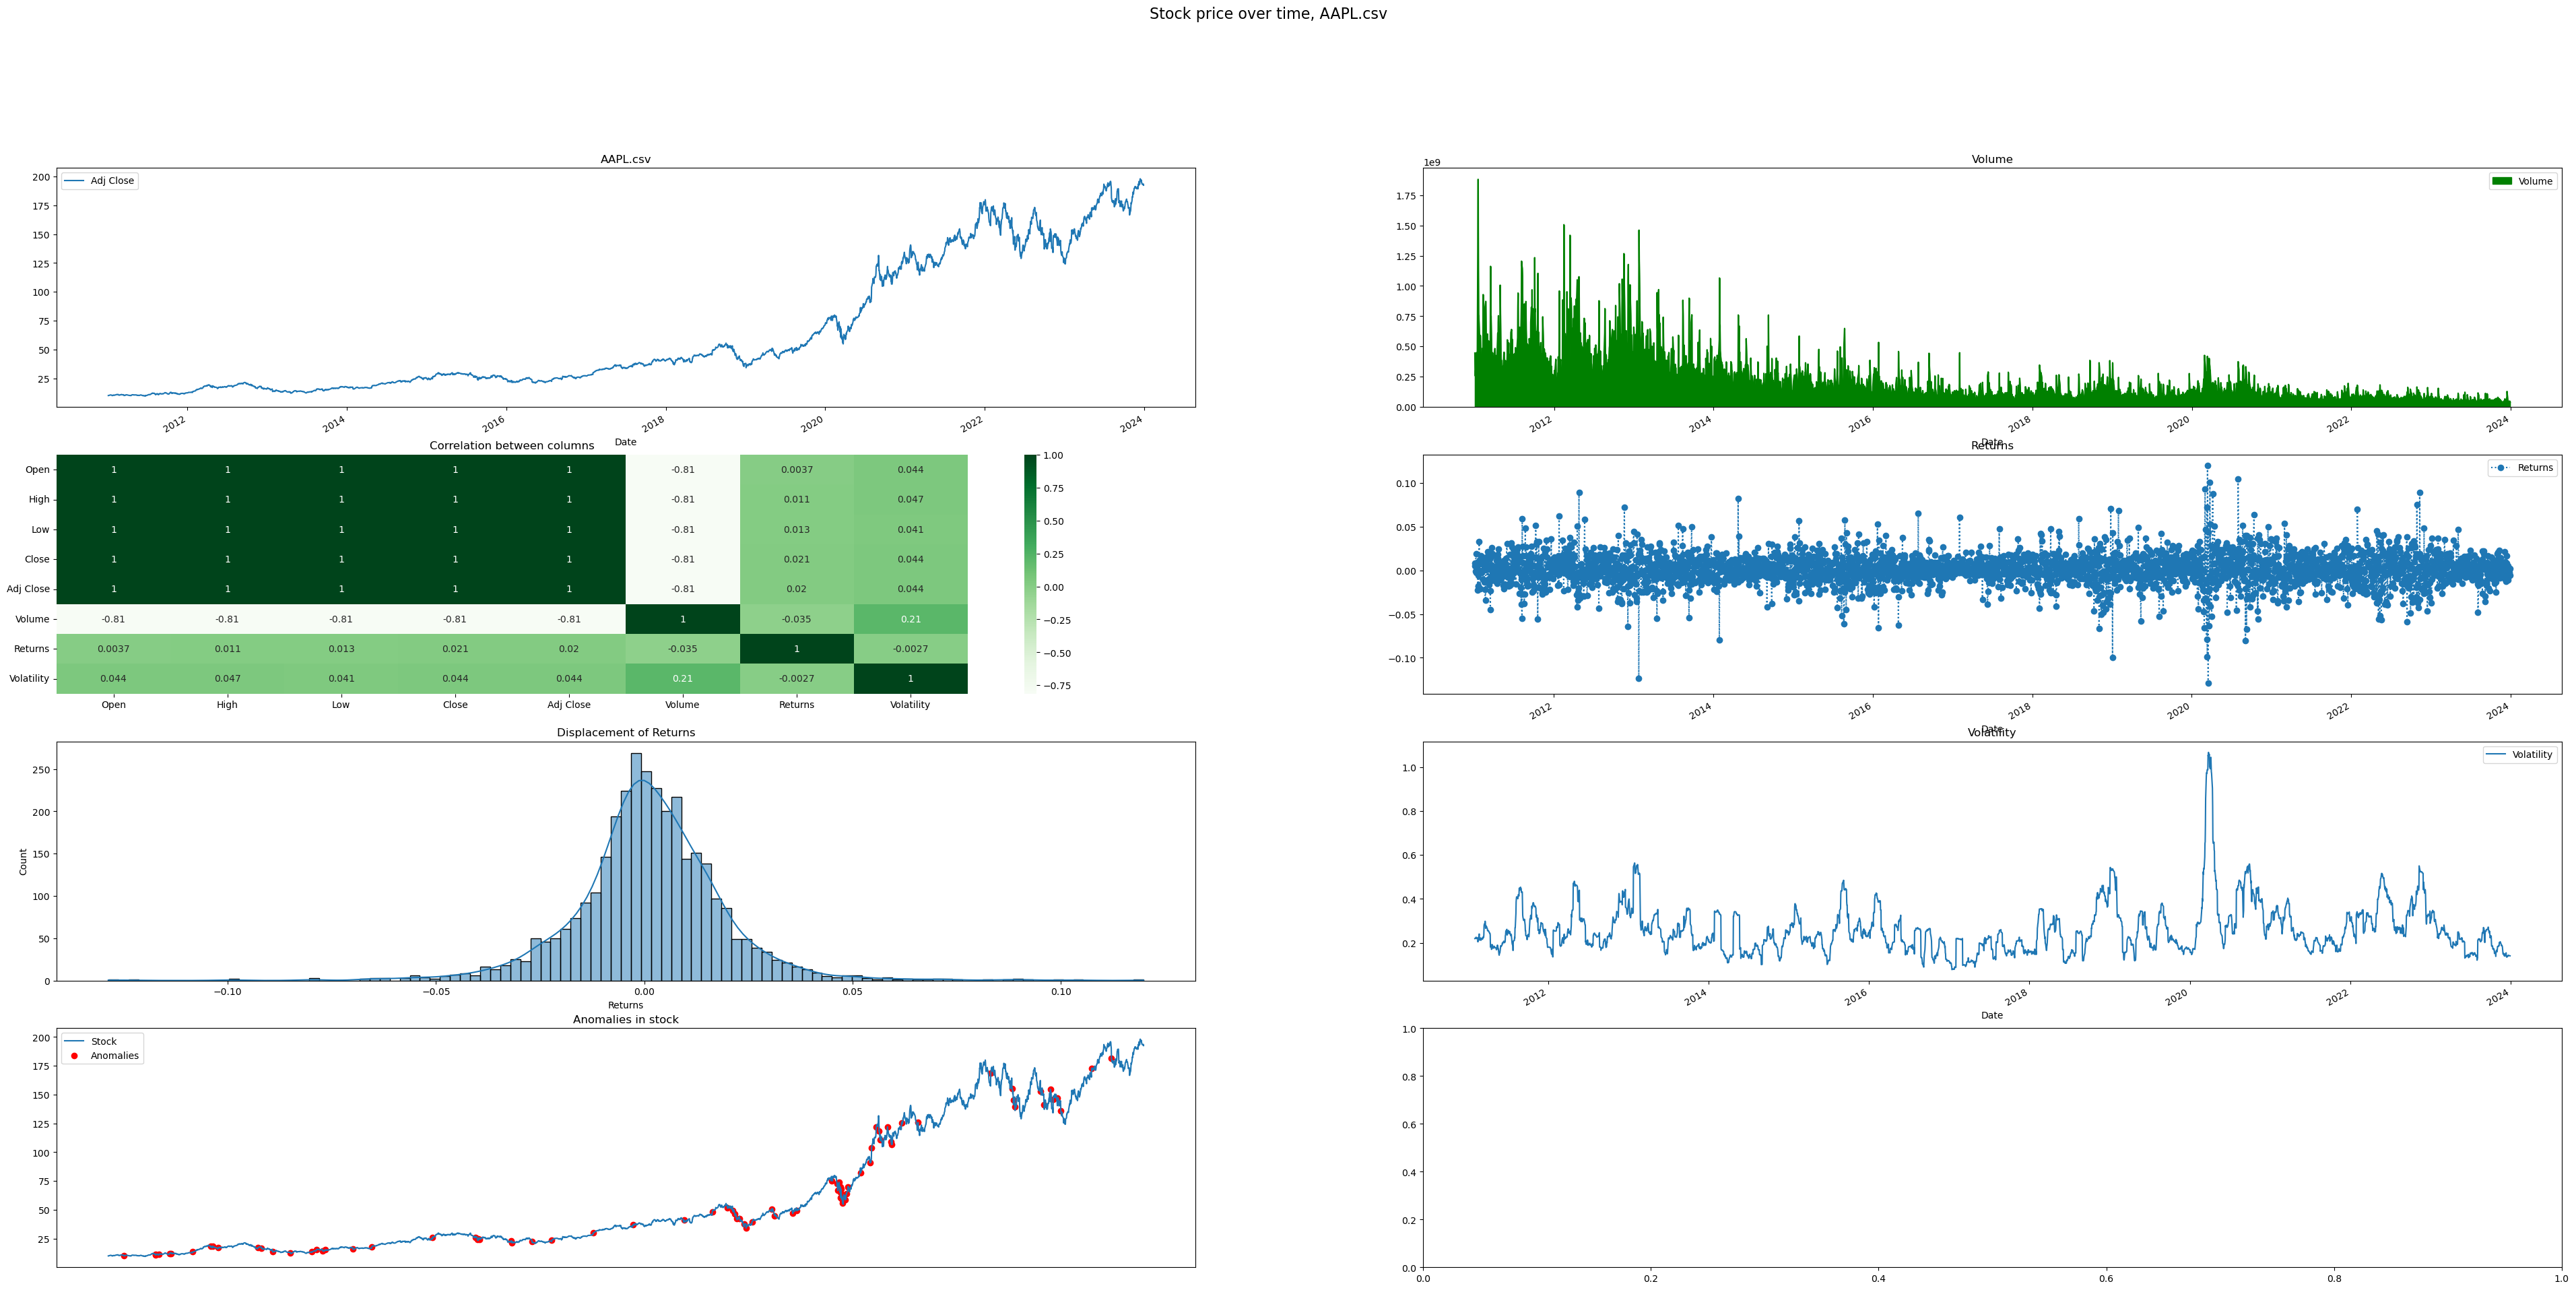

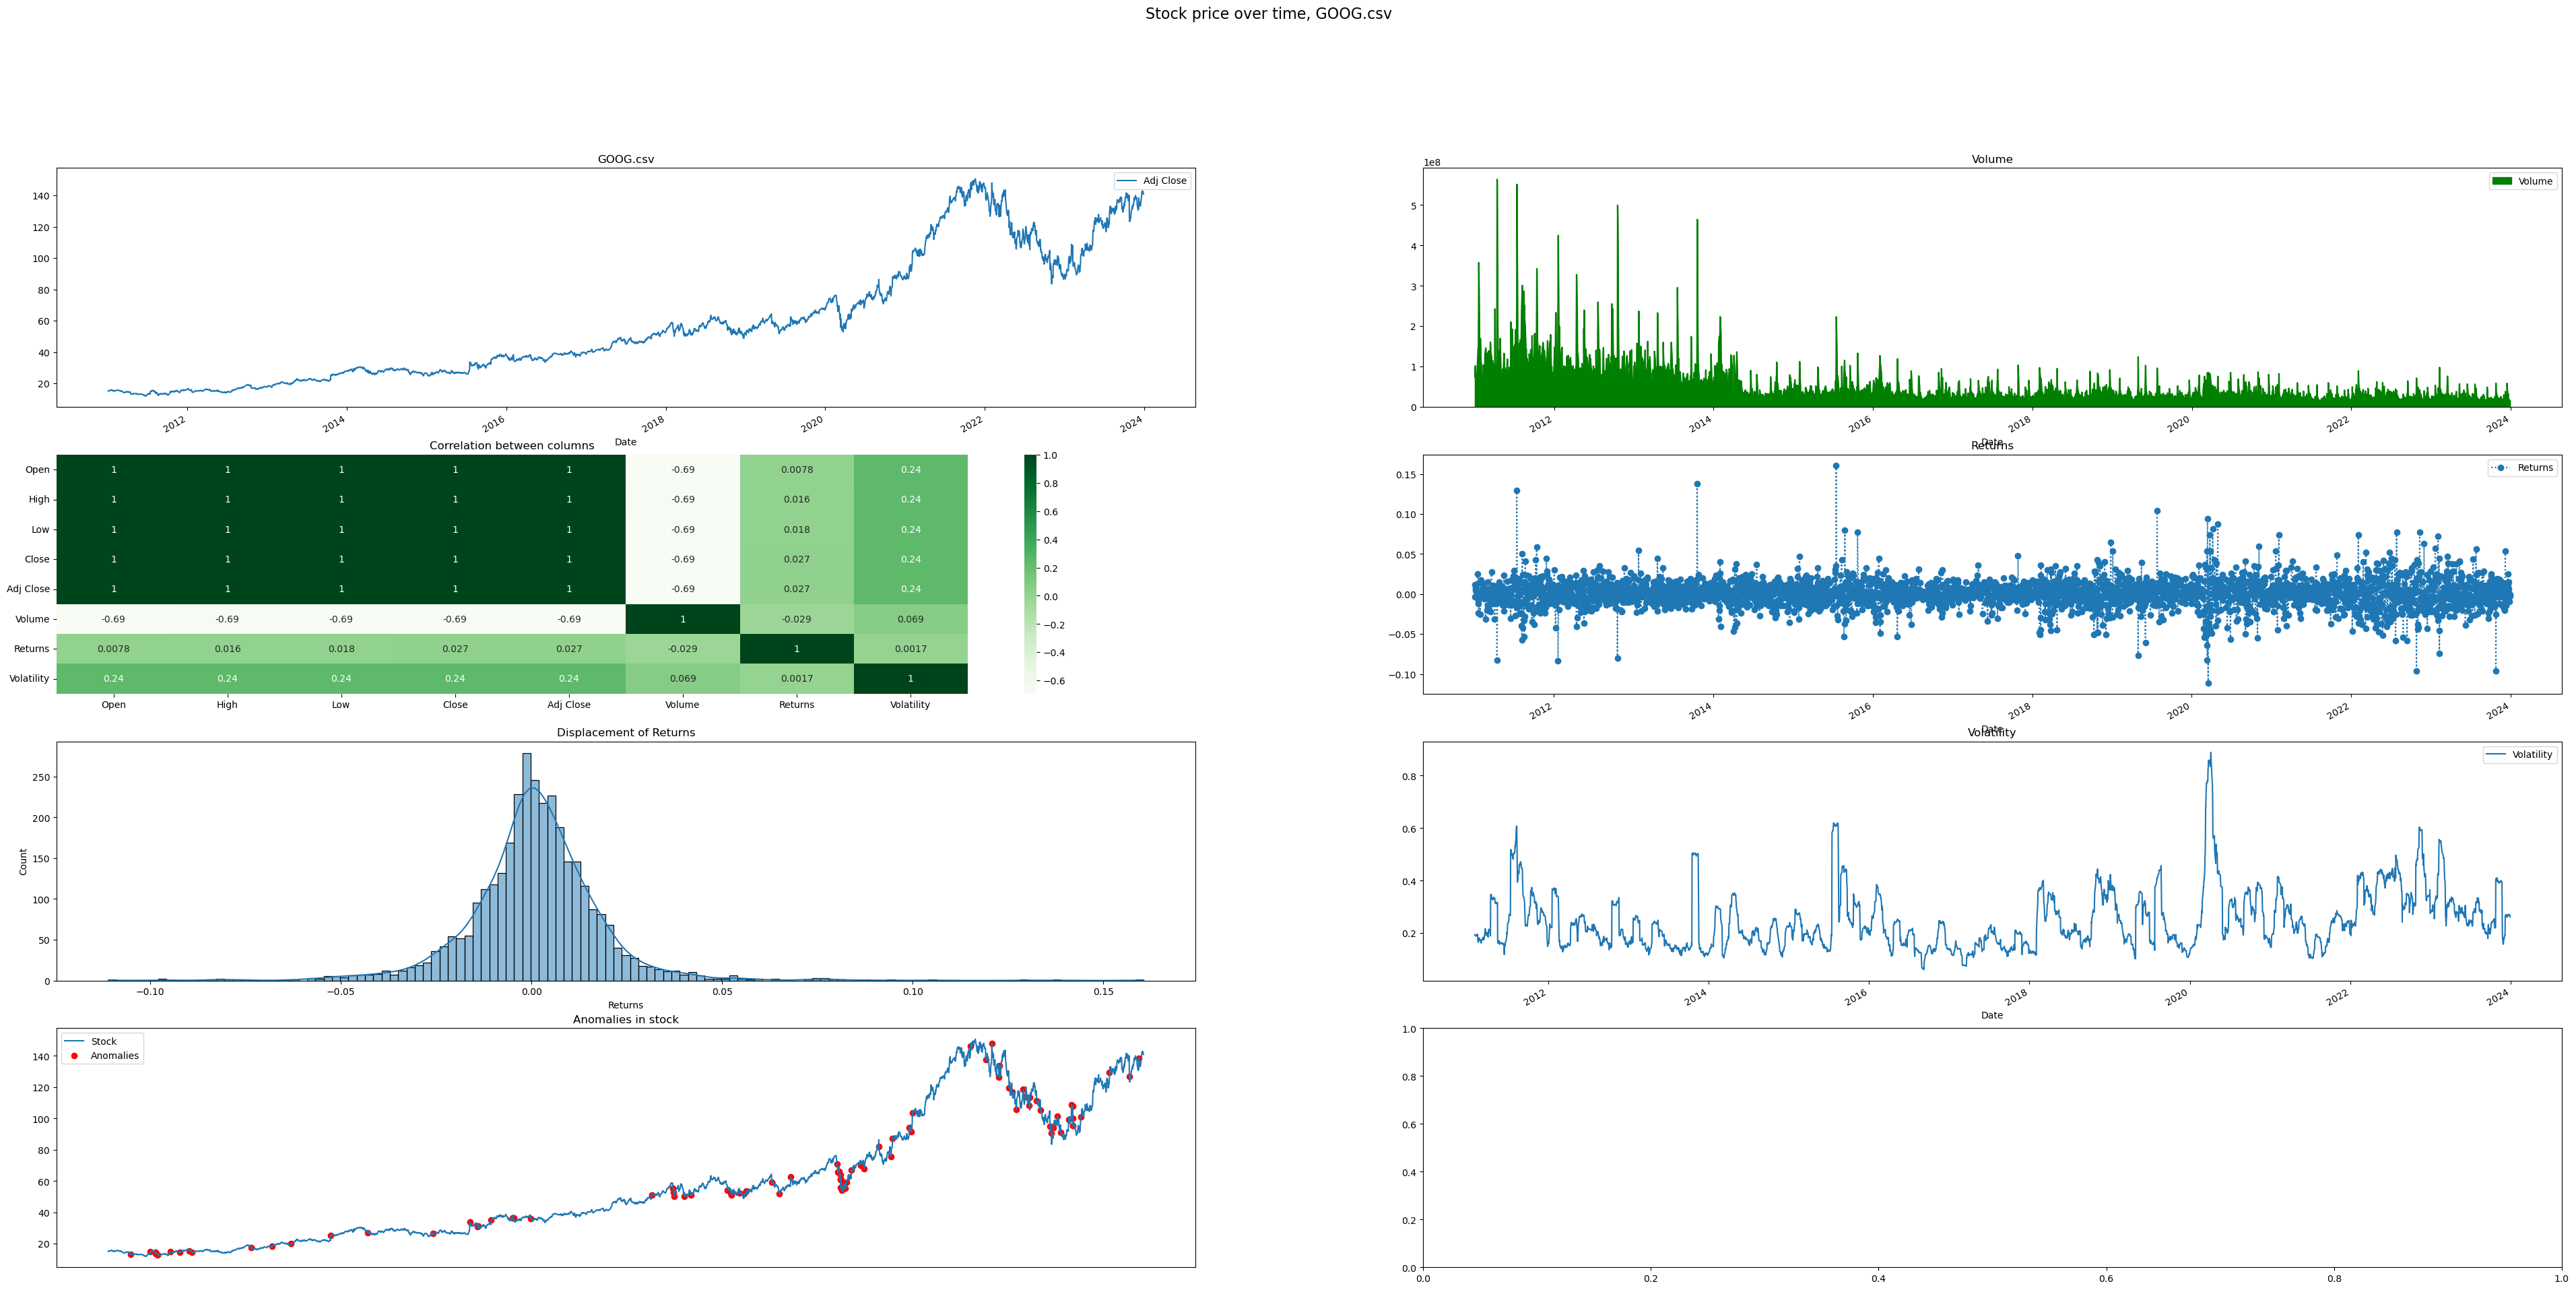

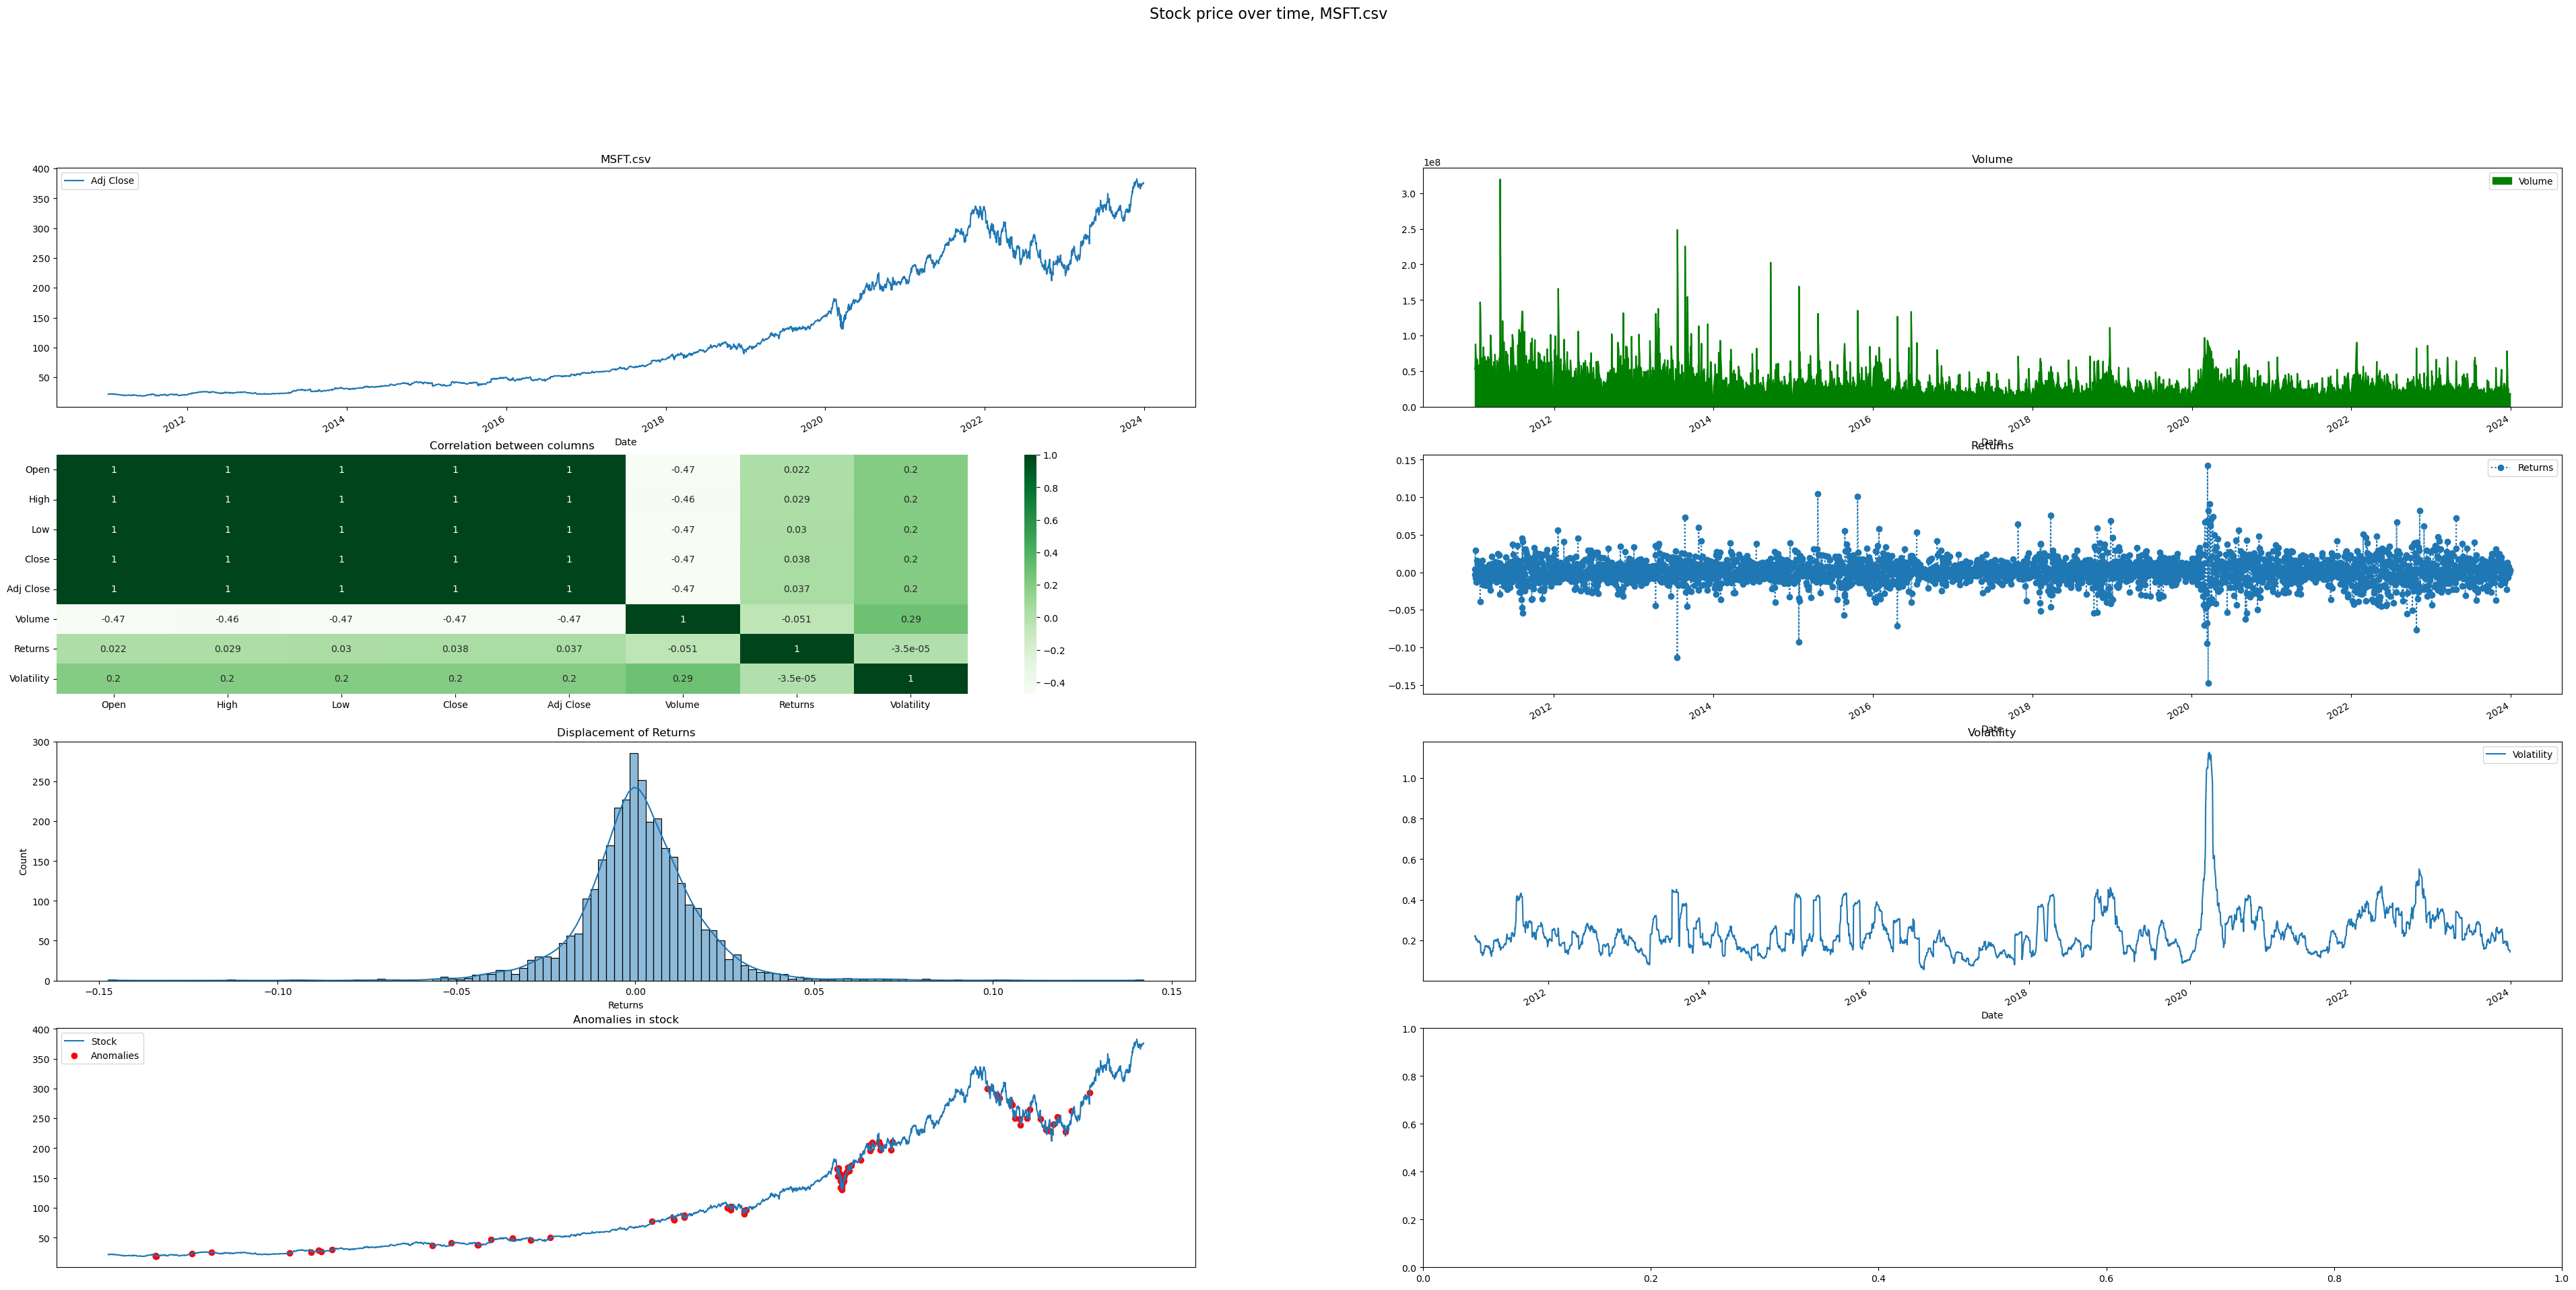

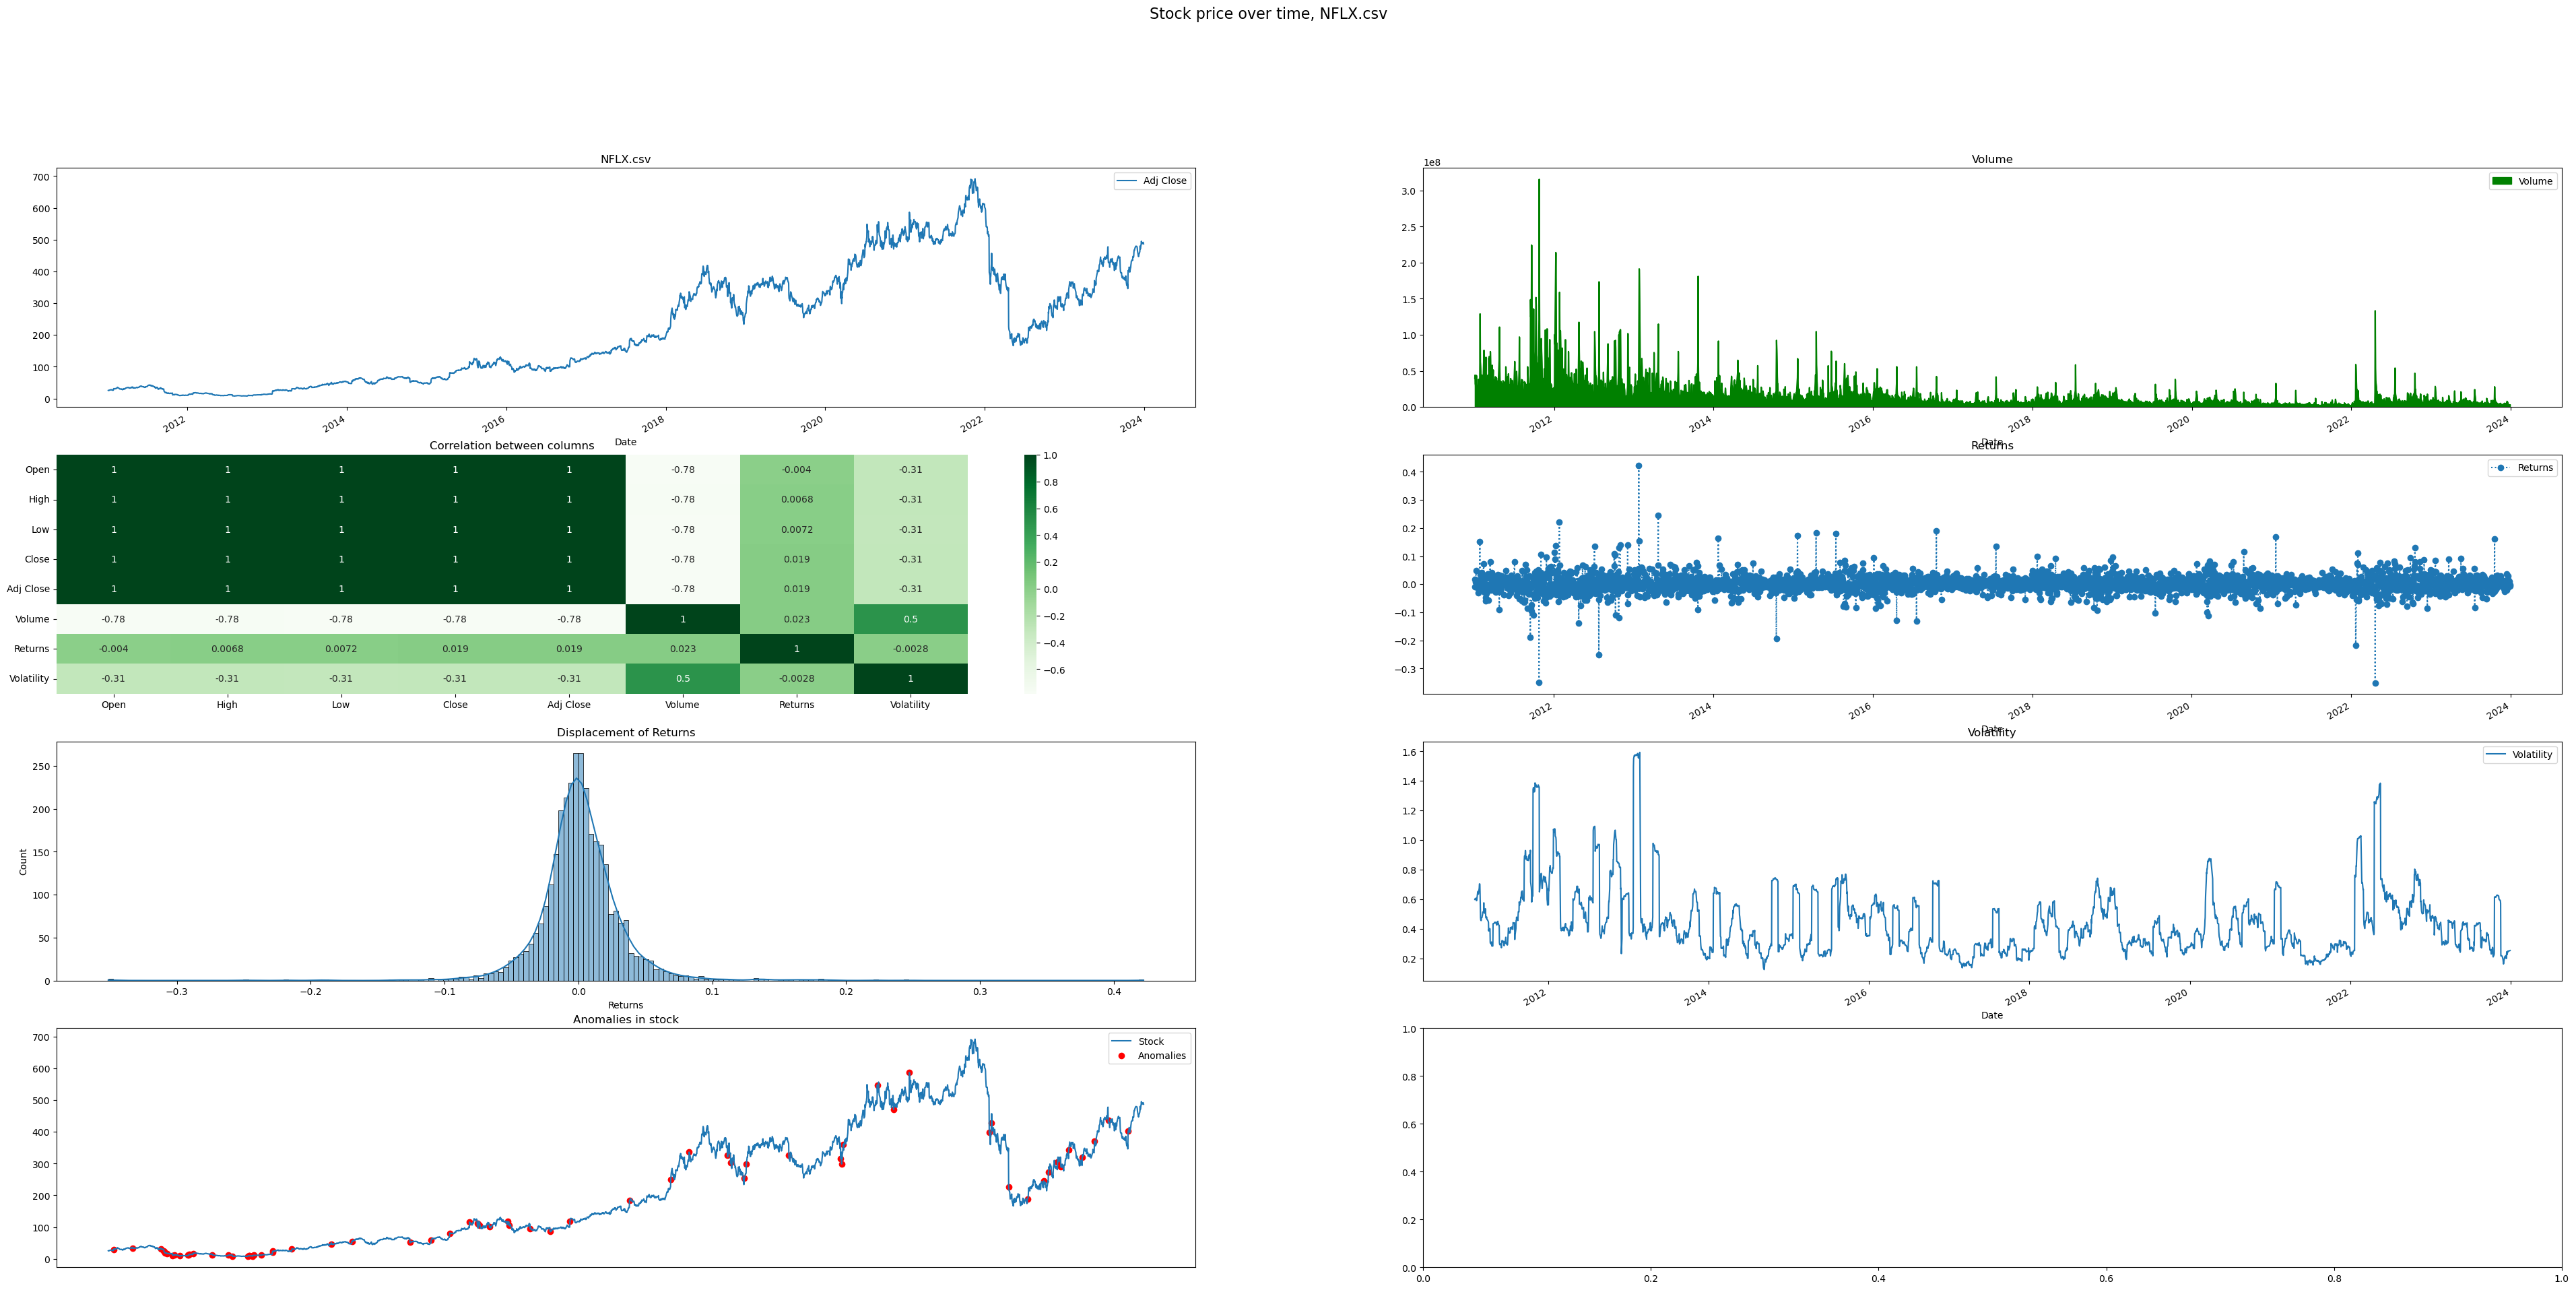

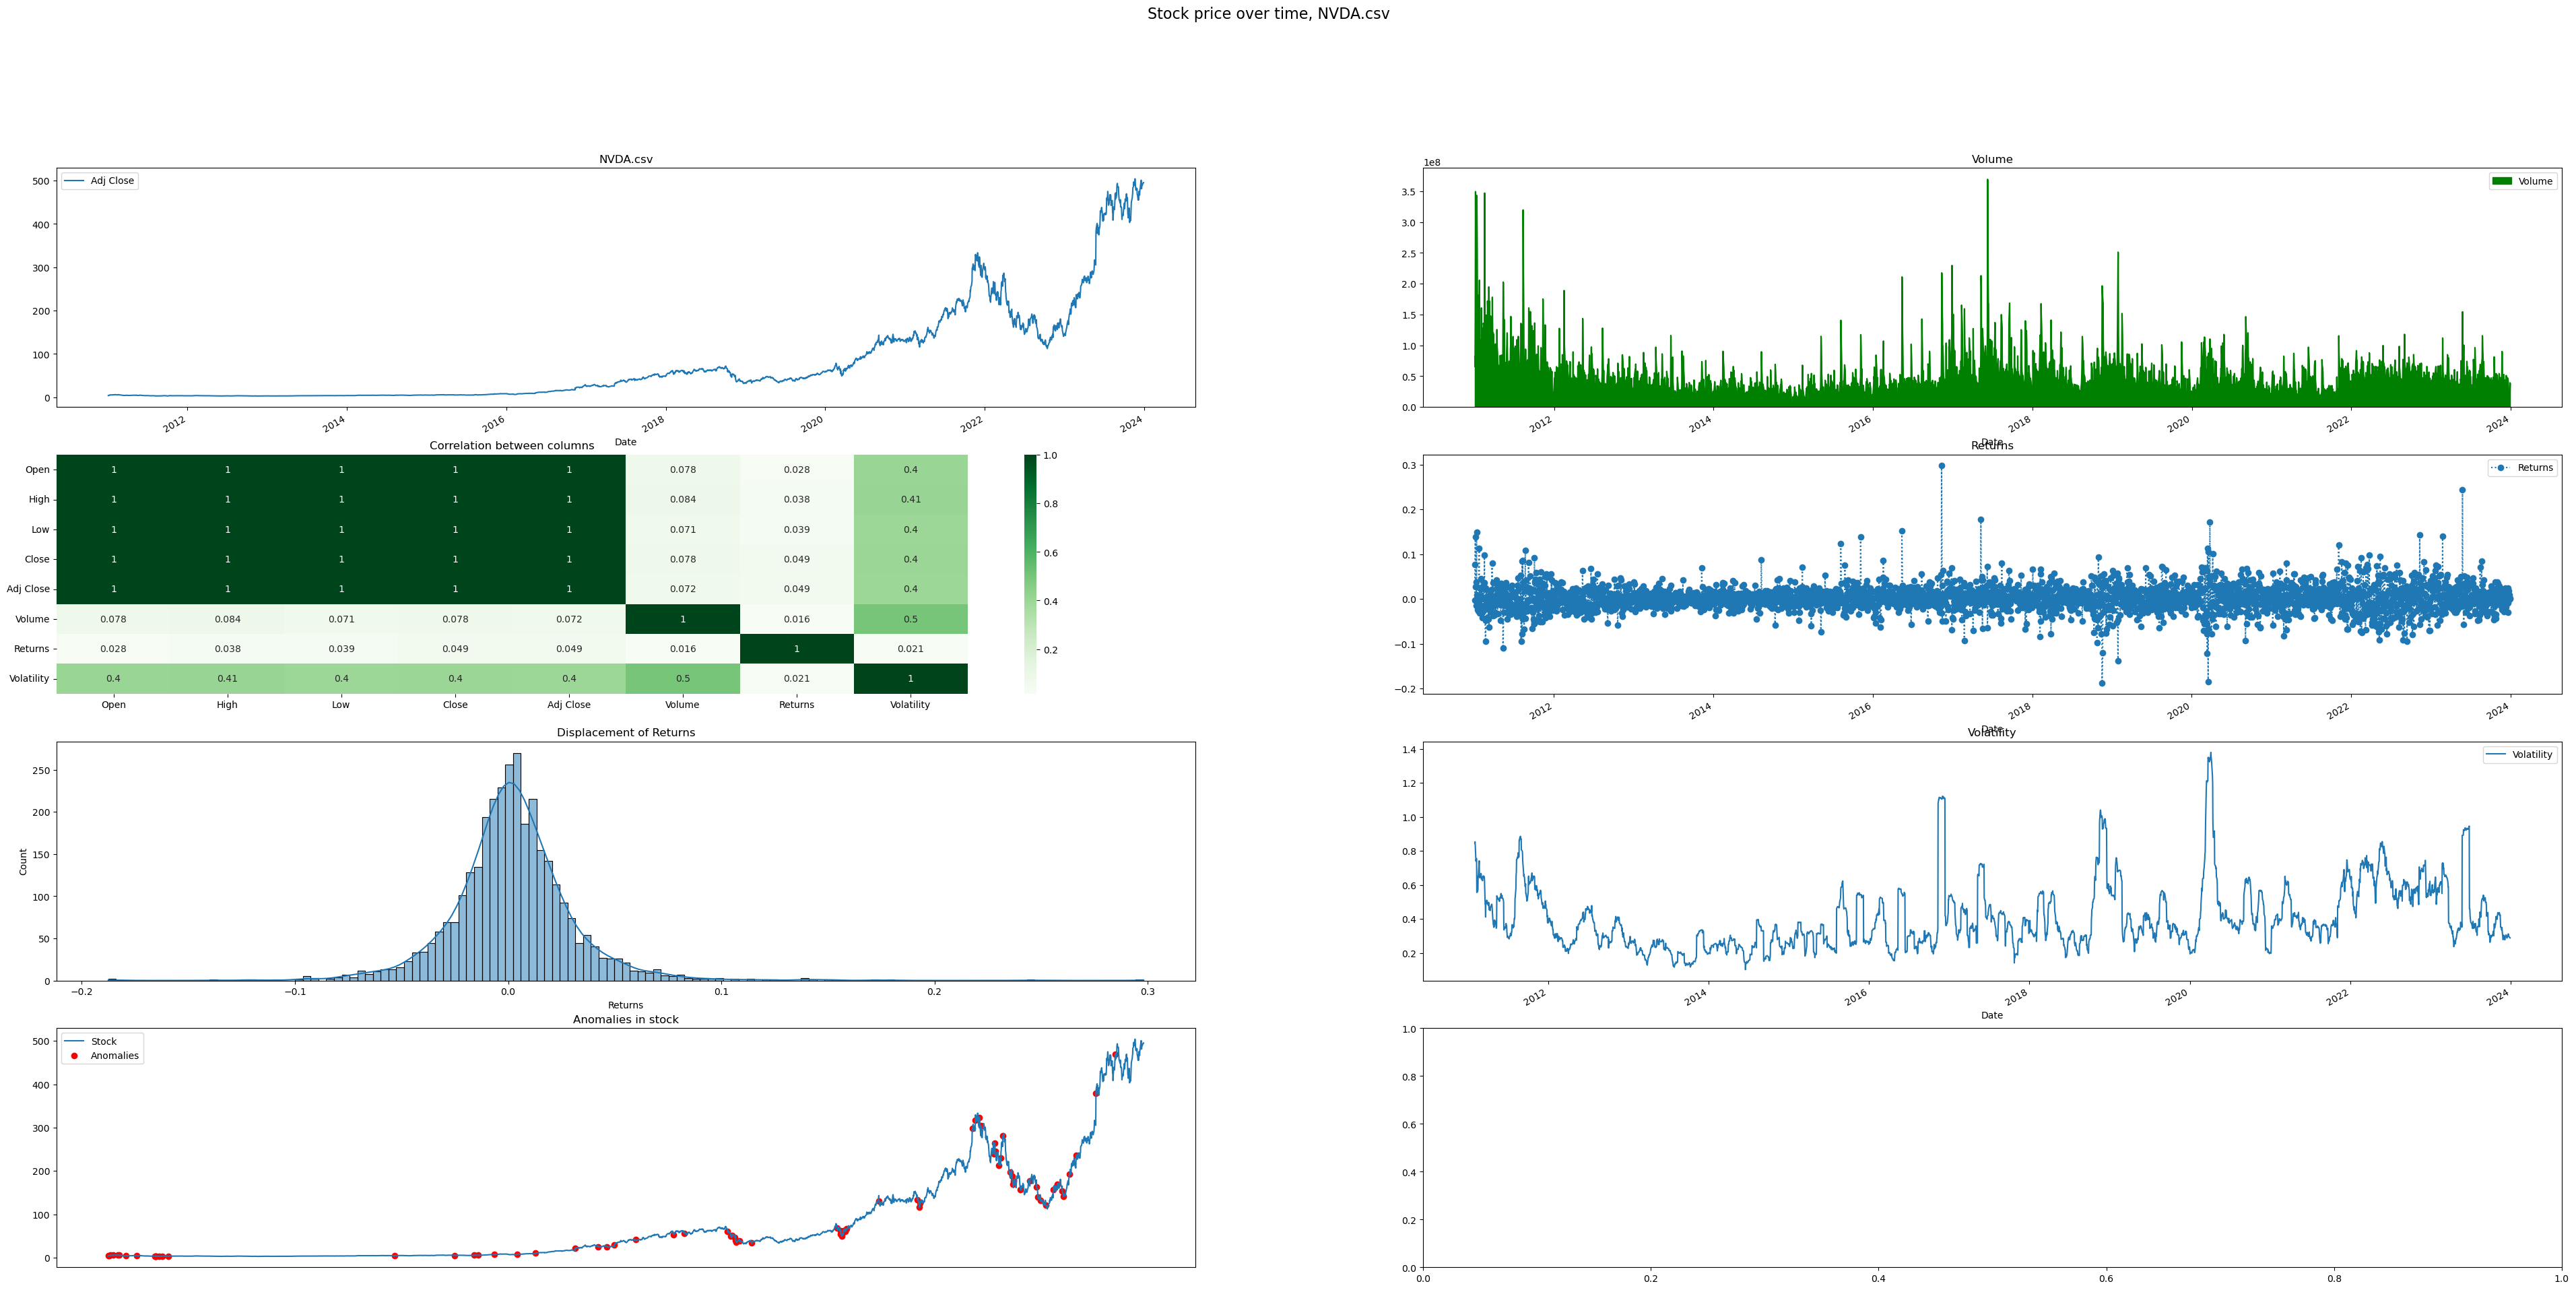

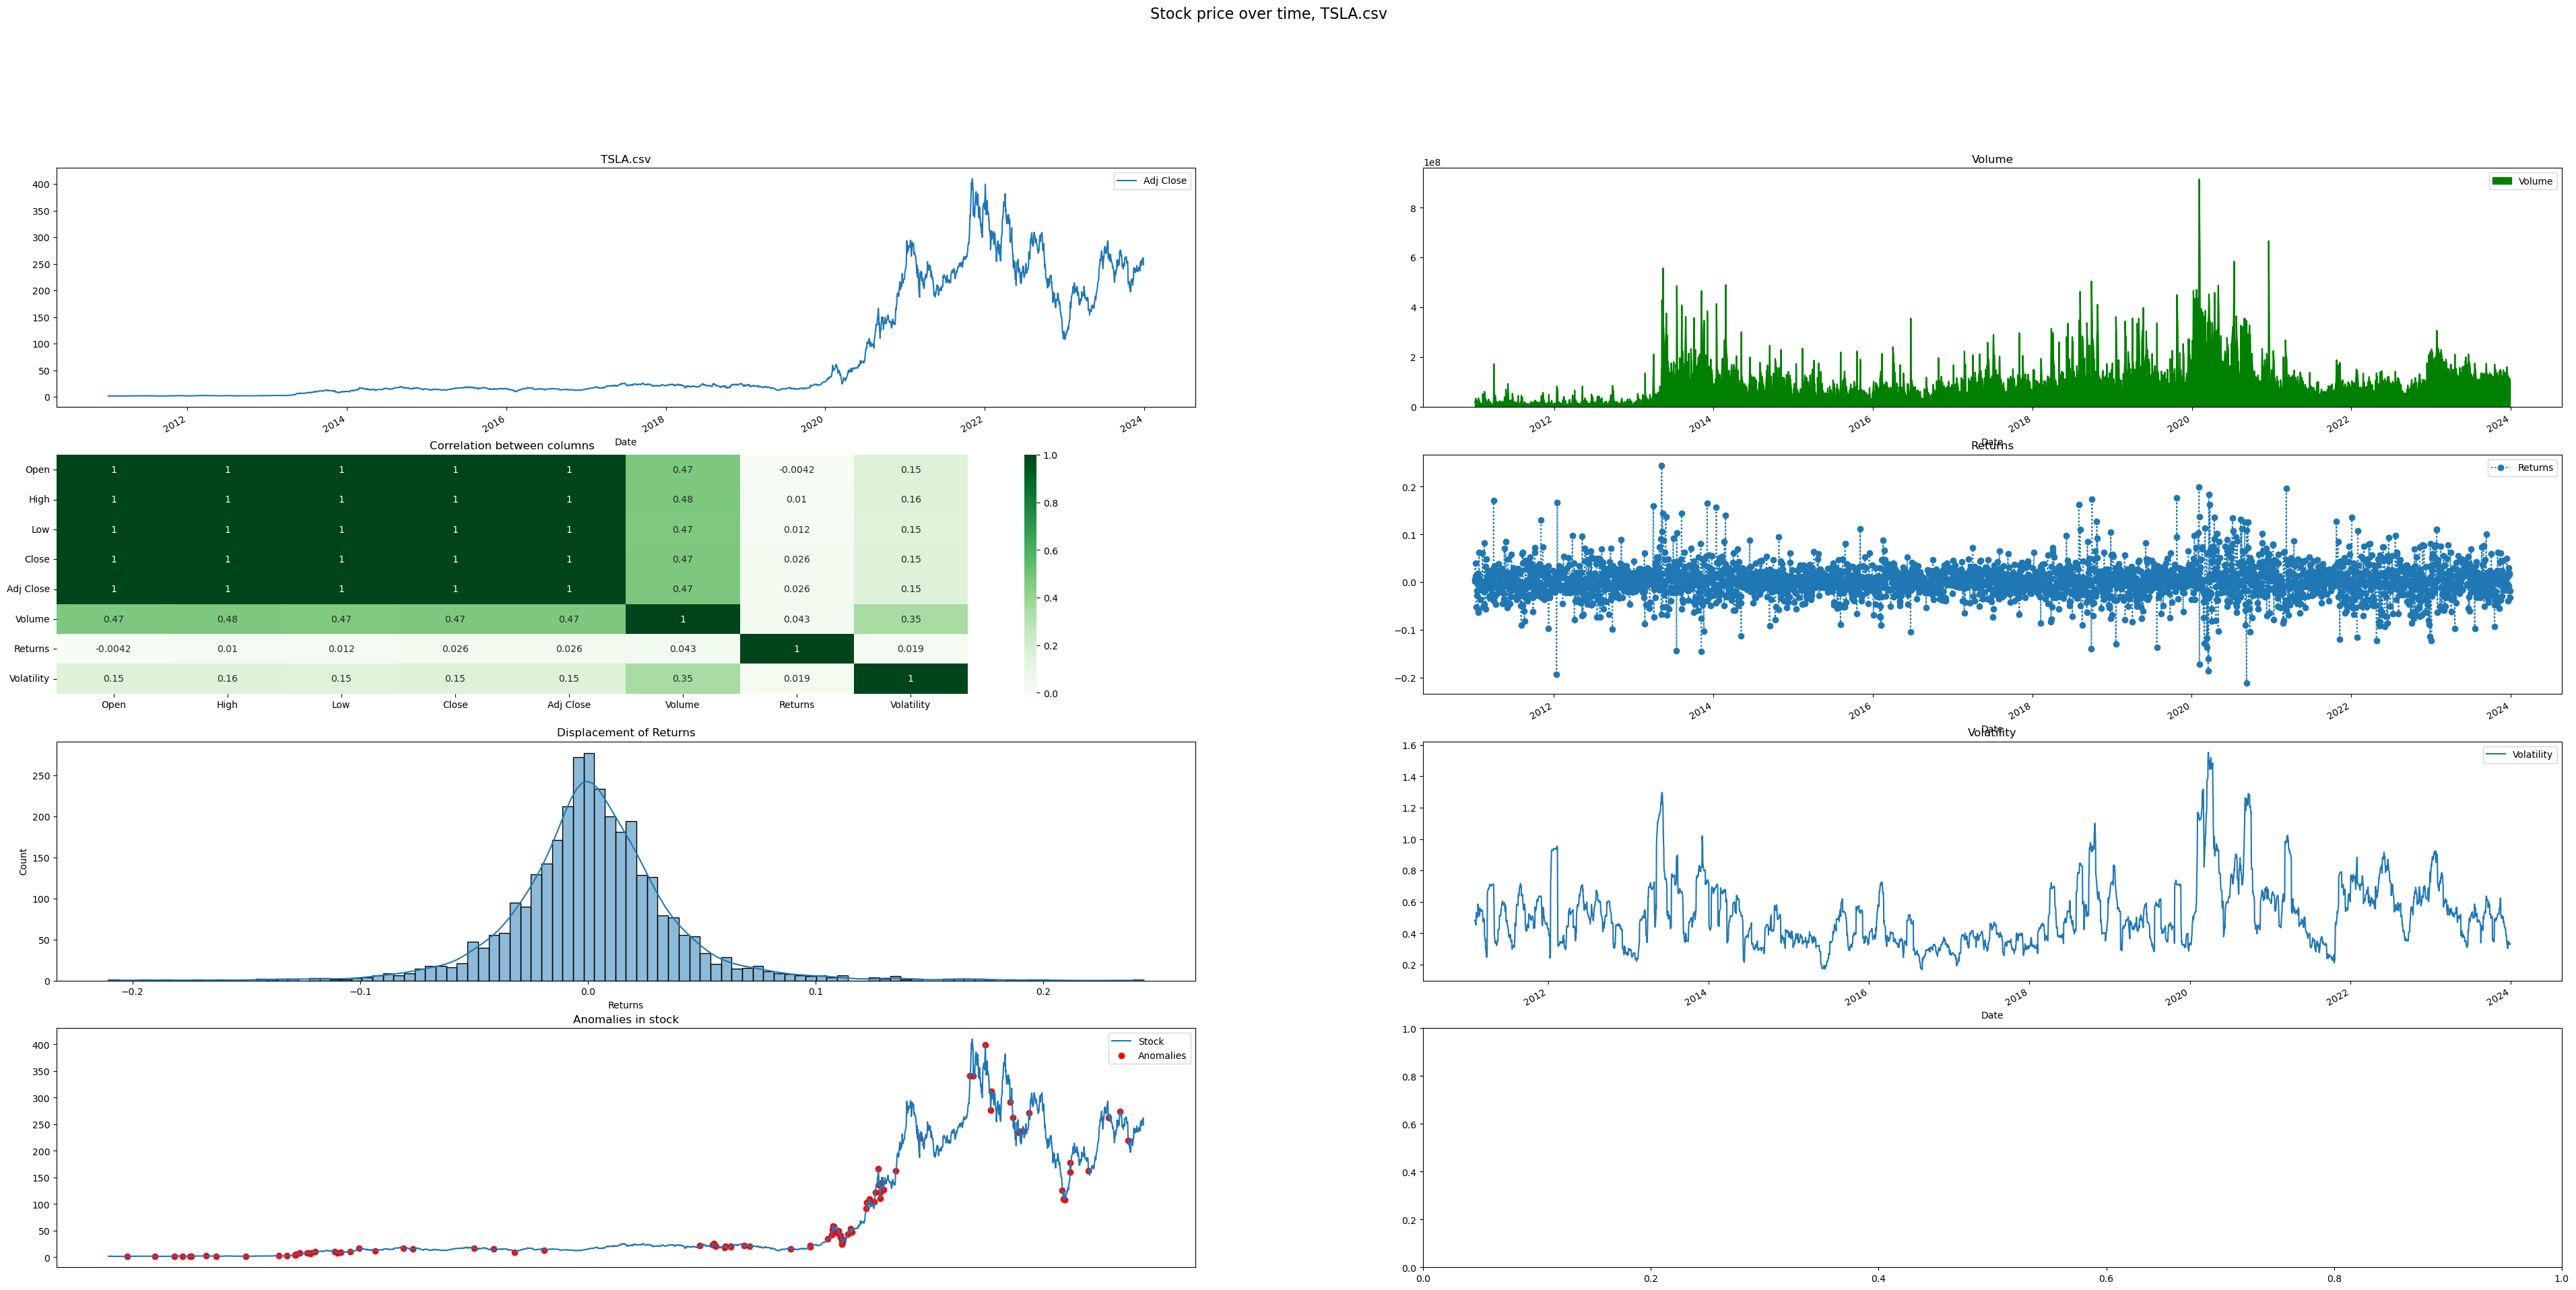

In [22]:
files = get_files_in_directory("unprocessed")
dataframes = []
for file in files:
    df = import_data_from_csv("unprocessed/" + file)
    df = convert_date_column_to_datetime(df)
    dataframes.append(df)



visualize_data_of_stocks_combined(dataframes, files)

for i in range(len(dataframes)):
    visualize_data(dataframes[i], ["Adj Close"], files[i])